In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import sys
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/")
from model import ConfigurableModel, ConfigurableModelWoBatchNorm, TestMotifModel, ConfigurableModel
import logomaker
import os
from wrapper import utils
from wrapper.utils import one_hot_to_sequence
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from torchinfo import summary

##Loading Data Model from Saved Weight

In [16]:
config = {'lr': 0.001, 'weight_decay': 0.1, 'cnn_first_filter': 24, 'cnn_first_kernel_size': 7, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 256, 'fc_size': 256}           
model = ConfigurableModel(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                        cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                        output_size=2)

def forward_to_RELU_1(model, x):
    for _, layer in enumerate(model.CNN): # Assuming there is defined "self.CNN" layer
        print(layer)
        x = layer(x)
        if isinstance(layer, nn.ReLU): # If it reaches ReLU, return the output 
            return x

def activation_pfm(layer_output: torch.Tensor, one_hot_selected_sequence_idx: torch.Tensor, window: int=9, threshold: float=0.75, by_threshold=False) -> np.ndarray:
    """
    Compute the Position Frequency Matrix (PFM) from a given torch layer output and one-hot-encoded selected_sequence_idx. Details are explained on the DeepBind supplementary material (10.2 Sequence logos). 
    Assuming the output of the CNN layer is "padded same". 
    
    input: layer_output: torch.Tensor, shape: ([batch, seq_length_out, num_cnn_layers])
    input: one_hot_sequence: torch.Tensor, shape: ([batch, seq_length, 4])
    input: window: int, size of the activation window (default 9)
    input: threshold: float, threshold to consider an activation (default 0.5)

    return: PFM: np.array, shape: ([num_filter_layer_output, window, 4])
    """
    input = layer_output.detach().cpu().numpy() # ([batch, seq_length_out, num_cnn_layers])
    X = one_hot_selected_sequence_idx.detach().cpu().numpy() # ([batch, seq_length, 4])





    seq_length = X.shape[1]
    pfm = []
    seq_align_one_hot=[]
    seq_align_text=[]
    total_padding = (window - 1)
    left_pad = total_padding // 2
    # Looping through all kernels -> np(batch,seq_length)
    for filter_index in range(input.shape[2]):
        # Get the maximum score for each selected_sequence_idx
        max_each_seq = np.max(input[:, :, filter_index], axis=1) #[batch]
        if by_threshold:
            max_at_filter = np.max(max_each_seq)
            print(f"Max at filter {filter_index}: {max_at_filter}")
            selected_sequence_idx = np.where(max_each_seq > max_at_filter*threshold)[0] # [batch], in ascending order
            print(f"selected_sequence_idx length: {selected_sequence_idx.shape}")
        else:
            sorted_seq_idx = np.argsort(max_each_seq) #[batch], in ascending order

            # Get the descending order of the sequence index for top 2000 (or less if it's not enough)
            seq_size = sorted_seq_idx.shape[0]
            sort_idx=1
            selected_sequence_idx = []
            while(sort_idx<=2000 and sort_idx<seq_size):
                # Descending
                selected_sequence_idx.append(sorted_seq_idx[-sort_idx])
                sort_idx+=1
            selected_sequence_idx = np.array(selected_sequence_idx)

        temp_seq_align_one_hot = []
        tem_seq_align_text = []
        if len(selected_sequence_idx)>0:
            # print(f"Processing filter: {filter_index}")
            max_indexes = np.argmax(input[list(selected_sequence_idx),:,filter_index], axis = 1) # [batch, seq_lengt] extract max position for each sequence
            # print(f"selected_sequence_idx : {selected_sequence_idx[0:5]}, max_indexes : {max_indexes[0:5]}")
            for seq_index, max_index in zip(selected_sequence_idx, max_indexes):
                # NOTE DIFFERENT 
                start_window = int(max_index) - int(left_pad)
                end_window = start_window + window - 1
                if (end_window > seq_length) or (start_window < 0):
                    # print("brek length, pass")
                    continue
                else : 
                    seq = X[seq_index, start_window:end_window, :] # select the one-hot encoded sequence based on the index
                    temp_seq_align_one_hot.append(seq)
                    tem_seq_align_text.append(one_hot_to_sequence(seq))
                # print(f"one hto seq : {seq}, seq text: {one_hot_to_sequence(seq)}")
                # print(seq)
                # print(one_hot_to_sequence(seq))   
            # print(f"shape of temp align: {np.array(temp_seq_align_one_hot).shape}")
            pfm.append(np.sum(np.array(temp_seq_align_one_hot), axis=0)) # create Position Frequency Matrix, summin over all selected_sequence_idx(batch)

            seq_align_one_hot.append(np.array(temp_seq_align_one_hot))
            seq_align_text.append(np.array(tem_seq_align_text))
        else:
            # If no sequence pass the threshold on a filter, add a zero matrix
            print("No sequence pass the threshold. Adding zero matrix")
            pfm.append(np.zeros((window, 4)))
            seq_align_one_hot.append(np.zeros((window, 4)))
            seq_align_text.append(np.array("N"*window))
    print(np.array(seq_align_text[0]).shape)
    return pfm, seq_align_text, seq_align_one_hot

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
#BY ORDERING
fold = 1
for fold in [1,2,3,4,5]:
    model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.pkl",
                            map_location=torch.device('cpu'))
    model.load_state_dict(model_weight)
    model.eval()

    seq_fasta_test_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
    seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

    with torch.no_grad():
        first_layer_result = forward_to_RELU_1(model, seq_fasta_one_hot)
    print("extract kernel_size")
    kernel_size = model.CNN[0].kernel_size[0]

    pfm, seqs_text, seqs_one_hot = activation_pfm(first_layer_result.transpose(1,2).detach().cpu(),
                     seq_fasta_one_hot.transpose(1,2).detach().cpu(),
                     window=config["cnn_first_kernel_size"])
    # print(pfm.shape)

    seq_dict = {f'filter_{i+1}': record for i, record in enumerate(seqs_text)}
    np.savez(f"first_layer_fold_{fold}_seqs_fixed_tune.npz", **seq_dict, allow_pickle = True)

Conv1d(4, 24, kernel_size=(7,), stride=(1,), padding=same)
ReLU()
extract kernel_size
(2000,)
Conv1d(4, 24, kernel_size=(7,), stride=(1,), padding=same)
ReLU()
extract kernel_size
(2000,)
Conv1d(4, 24, kernel_size=(7,), stride=(1,), padding=same)
ReLU()
extract kernel_size
(2000,)
Conv1d(4, 24, kernel_size=(7,), stride=(1,), padding=same)
ReLU()
extract kernel_size
(2000,)
Conv1d(4, 24, kernel_size=(7,), stride=(1,), padding=same)
ReLU()
extract kernel_size
(2000,)


In [6]:
print(model.__class__.__name__)
summary(model, verbose=1, col_width=15, input_size=(64, 4, 1001),  col_names=["input_size", "output_size", "num_params",  "params_percent", "trainable"])


ConfigurableModel
Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Param %         Trainable
ConfigurableModel                        [64, 4, 1001]   [64, 2]         --                   --         True
├─Sequential: 1-1                        [64, 4, 1001]   [64, 32, 125]   --                   --         True
│    └─Conv1d: 2-1                       [64, 4, 1001]   [64, 24, 1001]  696               0.00%         True
│    └─ReLU: 2-2                         [64, 24, 1001]  [64, 24, 1001]  --                   --         --
│    └─Dropout: 2-3                      [64, 24, 1001]  [64, 24, 1001]  --                   --         --
│    └─BatchNorm1d: 2-4                  [64, 24, 1001]  [64, 24, 1001]  48                0.00%         True
│    └─MaxPool1d: 2-5                    [64, 24, 1001]  [64, 24, 500]   --                   --         --
│    └─Conv1d: 2-6                       [64, 24, 500]   [64, 32, 500]   5,408             0.03%       

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Param %         Trainable
ConfigurableModel                        [64, 4, 1001]   [64, 2]         --                   --         True
├─Sequential: 1-1                        [64, 4, 1001]   [64, 32, 125]   --                   --         True
│    └─Conv1d: 2-1                       [64, 4, 1001]   [64, 24, 1001]  696               0.00%         True
│    └─ReLU: 2-2                         [64, 24, 1001]  [64, 24, 1001]  --                   --         --
│    └─Dropout: 2-3                      [64, 24, 1001]  [64, 24, 1001]  --                   --         --
│    └─BatchNorm1d: 2-4                  [64, 24, 1001]  [64, 24, 1001]  48                0.00%         True
│    └─MaxPool1d: 2-5                    [64, 24, 1001]  [64, 24, 500]   --                   --         --
│    └─Conv1d: 2-6                       [64, 24, 500]   [64, 32, 500]   5,408             0.03%         True
│    └─ReLU

In [18]:
seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)
with torch.no_grad():
    first_layer_result = forward_to_RELU_1(model, seq_fasta_one_hot)
print("extract kernel_size")
kernel_size = model.CNN[0].kernel_size[0]
first_layer_result.shape
first_layer_result

Conv1d(4, 24, kernel_size=(7,), stride=(1,), padding=same)
ReLU()
extract kernel_size


tensor([[[0.0000, 0.0000, 0.1309,  ..., 0.0000, 0.3246, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1469, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2162, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1998, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1640, 0.0000],
         [0.0314, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0536, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.1904,  ..., 0.2450, 0.2892, 0.0000],
         [0.0000, 0.0000, 0.3894,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0725,  ..., 0.0000, 0.0000, 0.

## Plot First CNN Layer Logo

eval
Conv1d(4, 16, kernel_size=(9,), stride=(1,), padding=same)
ReLU()
extract kernel_size


In [19]:
first_cnn_weight = model_weight["CNN.CNN_1.weight"]
print(first_cnn_weight.shape) # (num_filter, 4, kernel_size)
print(first_cnn_weight)

torch.Size([24, 4, 7])
tensor([[[-7.2712e-02,  1.1145e-01, -6.3236e-02, -1.0310e-01, -9.4678e-03,
          -7.5278e-02, -5.9294e-02],
         [ 2.1410e-02,  1.0068e-01, -1.8597e-02,  2.4535e-01,  2.6763e-02,
           4.1115e-01,  3.4960e-02],
         [ 3.7576e-02,  7.3128e-02, -2.3505e-01, -1.7199e-01,  6.2613e-03,
          -3.7104e-01,  9.7600e-02],
         [ 1.6261e-02,  1.1685e-01,  1.0173e-03,  1.0439e-01, -1.3416e-02,
          -1.0193e-01, -2.1301e-01]],

        [[ 1.0163e-01,  3.0788e-02,  6.6694e-03, -3.4137e-01, -6.9361e-02,
           8.6761e-02, -7.7303e-02],
         [-2.4065e-02,  9.0311e-02, -2.8403e-02, -5.2608e-02, -2.9353e-01,
          -5.1497e-02, -6.4905e-03],
         [-9.7930e-02,  7.1068e-02, -3.9648e-01,  1.5790e-01, -4.4046e-02,
          -2.1306e-01, -1.0128e-01],
         [ 3.5634e-04, -6.5684e-02,  2.5034e-01, -4.4119e-02,  1.1185e-01,
          -7.7320e-02,  4.7882e-03]],

        [[-8.3449e-02,  2.6424e-01,  8.3520e-02, -2.0332e-01, -2.8668e-01,
  

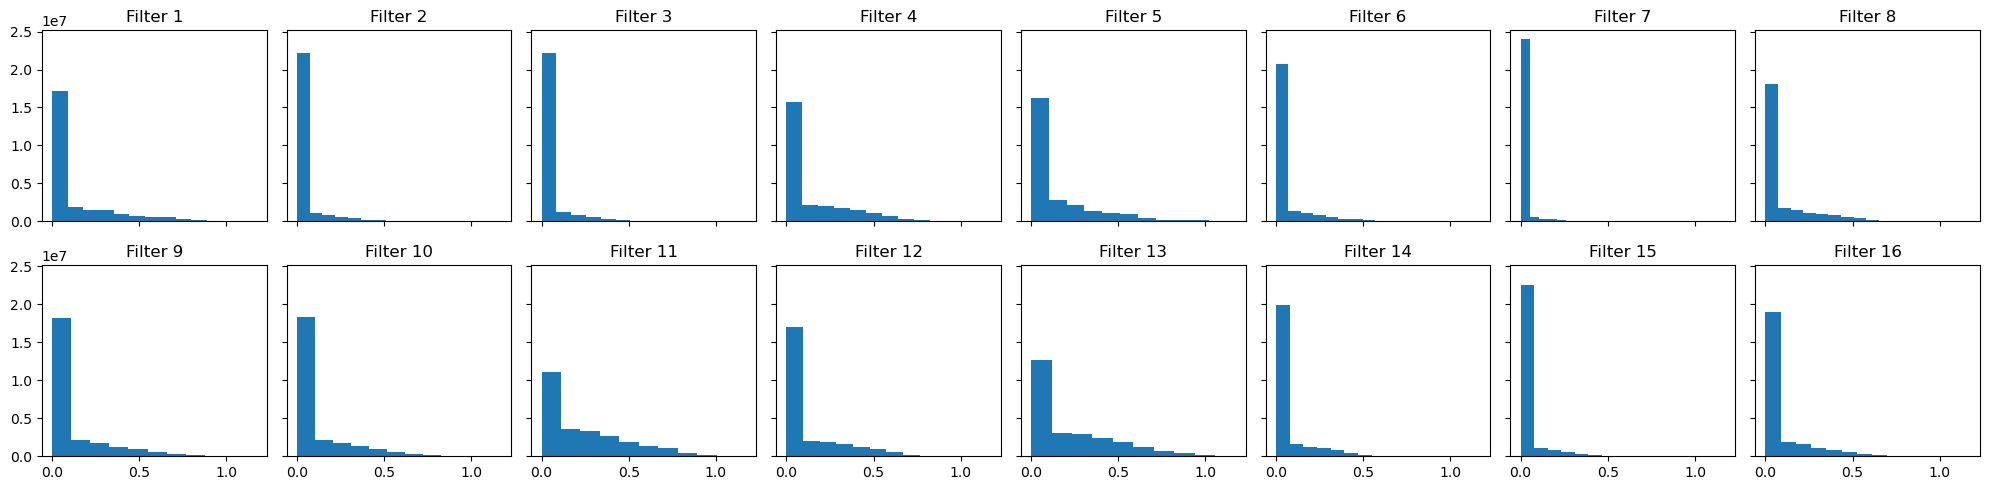

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

temp = first_layer_result.transpose(1,2)

fig, axs = plt.subplots(2, 8, sharey=True, sharex=True, tight_layout=True, figsize=(20, 5))

for i in range (0, 16):
    axs[i // 8, i % 8].title.set_text(f"Filter {i+1}")
    axs[i // 8, i % 8].hist(temp[:,:,i].flatten().detach().cpu().numpy())


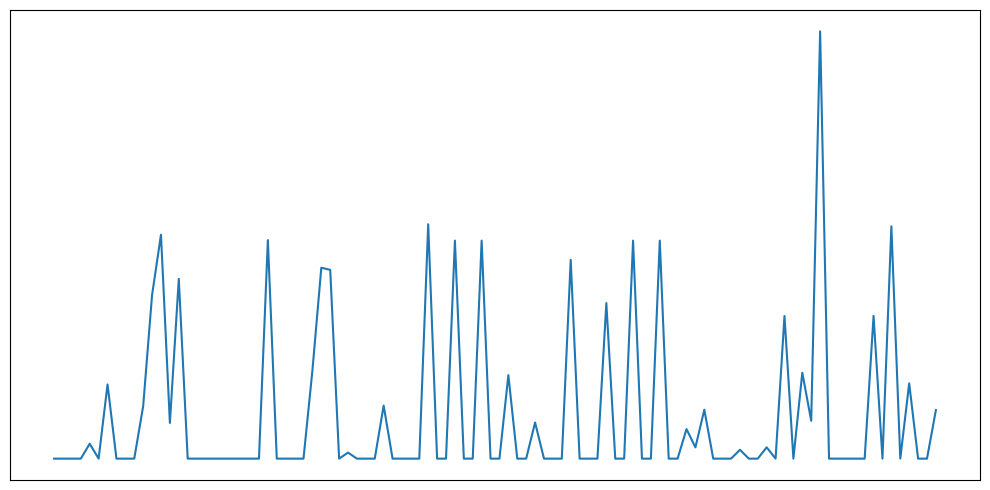

In [30]:

temp2 = first_layer_result.transpose(1,2)[0,900:1000,:].detach().cpu().numpy()

# fig, axs = plt.subplots(2, 8, sharey=True, sharex=True, tight_layout=True, figsize=(20, 5))
fig, axs = plt.subplots(1, 1, sharey=True, sharex=True, tight_layout=True, figsize=(10, 5))
i = 9
# axs.title.set_text(f"Filter {i+1}")
axs.plot(np.arange(0,len(temp2[:,i])),temp2[:,i] )
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)


# for i in range (2, 8):
#     axs[i // 8, i % 8].title.set_text(f"Filter {i+1}")
#     axs[i // 8, i % 8].plot(np.arange(0,len(temp2[:,i])),temp2[:,i] )

In [4]:
def activation_pfm(layer_output: torch.Tensor, one_hot_selected_sequence_idx: torch.Tensor, window: int=9, threshold: float=0.5) -> np.ndarray:
    """
    Compute the Position Frequency Matrix (PFM) from a given torch layer output and one-hot-encoded selected_sequence_idx. Details are explained on the DeepBind supplementary material (10.2 Sequence logos). 
    
    input: layer_output: torch.Tensor, shape: ([batch, seq_length_out, num_cnn_layers])
    input: one_hot_sequence: torch.Tensor, shape: ([batch, seq_length, 4])
    input: window: int, size of the activation window (default 9)
    input: threshold: float, threshold to consider an activation (default 0.5)

    return: PFM: np.array, shape: ([num_filter_layer_output, window, 4])
    """
    input = layer_output.detach().cpu().numpy() # ([batch, seq_length_out, num_cnn_layers])
    X = one_hot_selected_sequence_idx.detach().cpu().numpy() # ([batch, seq_length, 4])

    seq_length = X.shape[1]
    pfm = []
    seq_align_one_hot=[]
    seq_align_text=[]
    window_left = int(window/2)
    window_right = window - window_left
    # Looping through all kernels -> np(batch,seq_length)
    for filter_index in range(input.shape[2]):
        # Get the maximum score for each selected_sequence_idx
        max_each_seq = np.max(input[:, :, filter_index], axis=1) #[batch]
        sorted_seq_idx = np.argsort(max_each_seq) #[batch], in ascending order

        # Get the descending order of the sequence index for top 2000 (or less if it's not enough)
        seq_size = sorted_seq_idx.shape[0]
        sort_idx=1
        selected_sequence_idx = []
        while(sort_idx<=2000 and sort_idx<seq_size):
            # Descending
            selected_sequence_idx.append(sorted_seq_idx[-sort_idx])
            sort_idx+=1
        selected_sequence_idx = np.array(selected_sequence_idx)
        temp_seq_align_one_hot = []
        tem_seq_align_text = []
        if len(selected_sequence_idx)>0:
            print(f"Processing filter: {filter_index}")
            max_indexes = np.argmax(input[list(selected_sequence_idx),:,filter_index], axis = 1) # [batch, seq_lengt] extract max position for each sequence
            # print(f"selected_sequence_idx : {selected_sequence_idx[0:5]}, max_indexes : {max_indexes[0:5]}")
            for seq_index, max_index in zip(selected_sequence_idx, max_indexes):
                start_window = int(max_index) - window//2
                end_window = int(max_index) + window//2 
                if end_window > seq_length:
                    # print("brek length, pass")
                    continue
                else : 
                    seq = X[seq_index, start_window:end_window, :] # select the one-hot encoded sequence based on the index
                    temp_seq_align_one_hot.append(seq)
                    tem_seq_align_text.append(one_hot_to_sequence(seq))
                # print(f"one hto seq : {seq}, seq text: {one_hot_to_sequence(seq)}")
                # print(seq)
                # print(one_hot_to_sequence(seq))   
            # print(f"shape of temp align: {np.array(temp_seq_align_one_hot).shape}")
            pfm.append(np.sum(np.array(temp_seq_align_one_hot), axis=0)) # create Position Frequency Matrix, summin over all selected_sequence_idx(batch)

            seq_align_one_hot.append(np.array(temp_seq_align_one_hot))
            seq_align_text.append(np.array(tem_seq_align_text))
        else:
            # If no sequence pass the threshold on a filter, add a zero matrix
            print("No sequence pass the threshold. Adding zero matrix")
            pfm.append(np.zeros((window, 4)))
            seq_align_one_hot.append(np.zeros((window, 4)))
            seq_align_text.append(np.array("N"*window))
    print(np.array(seq_align_text[0]).shape)
    return np.array(pfm), seq_align_text, seq_align_one_hot

In [5]:
# need to transpose to have the right shape for pfm calculation
pfm, seqs_text, seqs_one_hot = activation_pfm(first_layer_result.transpose(1,2).detach().cpu(),
                     seq_fasta_one_hot.transpose(1,2).detach().cpu(),
                     window=8, threshold=0.75)
print(pfm.shape)

Processing filter: 0
Processing filter: 1


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2000,) + inhomogeneous part.

In [107]:
for filter_idx, filter_seq in enumerate(seqs_text):
    seq_records = [SeqRecord(Seq(seq), id=f"filter_id={filter_idx}|seq{i+1}", description="") for i, seq in enumerate(filter_seq)]
    SeqIO.write(seq_records, f"sequence_filter_{filter_idx}.fasta", "fasta")

In [123]:
seq_dict = {f'filter_{i+1}': record for i, record in enumerate(seqs_text)}
np.savez(f"first_layer_fold_{fold}_seqs.npz", **seq_dict, allow_pickle = True)

In [12]:
def plot_motifs_from_pfm(pfm: np.ndarray, out_dir: str, file_name: str, interactive: bool=True) -> None:
    """
    Plot motifs from Position Frequency Matrix.
    modified from https://github.com/p-koo/learning_sequence_motifs/blob/master/code/deepomics/visualize.py

    input: pfm: np.ndarray, shape: ([num_filter_layer_output, window, 4])
    input: out_dir: str, output directory
    input: file_name: str, output file name
    """
    fig = plt.figure(figsize=(30,10))
    fig.suptitle("Learned Motifs from The First Layer of CNN", fontsize=20)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    num_filters = pfm.shape[0]
    num_cols = 5
    num_rows = int(np.ceil(num_filters/num_cols))
    for n, f in enumerate(pfm):
        # f in [window.4] shape
        ax = fig.add_subplot(num_rows, num_cols, n+1)
        # IC is the information content
        # calculated from relative entropy: \sum{bases}p(a)log_{2}\frac{p(a), background_freq(a)}
        # which is the same as \sum{bases}p(a)log_{2}{p(a)} + log_{2}{4}, assuming a uniform background distribution 
        n_bases = 4
        pfm_sum = np.sum(f, axis=1, keepdims=True)
        ppm = f / pfm_sum # calculating PPM
        IC = np.log2(n_bases) + np.sum(ppm * np.log2(ppm+1e-8), axis=1, keepdims=True) # avoid log(0) by add small value
        print(np.sum(IC))
        logo = IC*ppm 

        counts_df = pd.DataFrame(data=logo, columns=list("ACGT"))

        logomaker.Logo(counts_df, ax=ax)
        ax = plt.gca()
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        ax.xaxis.set_ticks_position("none")
        plt.title(f"FILTER {n+1}")
        plt.xticks([])
        plt.yticks([])

    if interactive:
        plt.show()
    else:
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        outfile = os.path.join(out_dir, f"{file_name}.pdf")
        fig.savefig(outfile, format="pdf", dpi=200, bbox_inches="tight")
        plt.close(fig)

In [13]:
plot_motifs_from_pfm(pfm, "/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/analysis", "test_logo", interactive=True)

AttributeError: 'list' object has no attribute 'shape'

<Figure size 3000x1000 with 0 Axes>

## Plot Logo from Integrated Gradient 

In [20]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import sys
sys.path.append("../")
from model import ConfigurableModel
import time
import logomaker
import os
from typing import Callable
import gc
from captum.attr import IntegratedGradients


# config = {"cnn_first_filter":16, "cnn_first_kernel_size":9, "cnn_length":3, "cnn_filter":32, "cnn_kernel_size":7, "bilstm_layer":3, "bilstm_hidden_size":128, "fc_size":64}
# model = ConfigurableModelWoBatchNorm(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
#                                 cnn_length=config["cnn_length"], cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
#                                 output_size=1)


config = {'cnn_first_filter': 16, 'cnn_first_kernel_size': 9, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 128, 'fc_size': 64}            
model = TestMotifModel(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                        cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                        output_size=2)
#fold
fold = 1
# model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_1th_fold_case_m6_info-no_promoter-False_wo_batch_norm_mse.pkl",
#                           map_location=torch.device('cpu'))
model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6_info-no_promoter-False_MOTIF.pkl",
                          map_location=torch.device('cpu'))
model.load_state_dict(model_weight)
model.eval()

for k, v in model_weight.items():
    print(k)
meta_data_test_json_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/test_meta_data_SPLIT_{fold}.json"
seq_fasta_test_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CNN.CNN_1.weight
CNN.CNN_1.bias
CNN.BATCHNORM_1.weight
CNN.BATCHNORM_1.bias
CNN.BATCHNORM_1.running_mean
CNN.BATCHNORM_1.running_var
CNN.BATCHNORM_1.num_batches_tracked
CNN.CNN_2.weight
CNN.CNN_2.bias
CNN.BATCHNORM_2.weight
CNN.BATCHNORM_2.bias
CNN.BATCHNORM_2.running_mean
CNN.BATCHNORM_2.running_var
CNN.BATCHNORM_2.num_batches_tracked
CNN.CNN_3.weight
CNN.CNN_3.bias
CNN.BATCHNORM_3.weight
CNN.BATCHNORM_3.bias
CNN.BATCHNORM_3.running_mean
CNN.BATCHNORM_3.running_var
CNN.BATCHNORM_3.num_batches_tracked
biLSTM.weight_ih_l0
biLSTM.weight_hh_l0
biLSTM.bias_ih_l0
biLSTM.bias_hh_l0
biLSTM.weight_ih_l0_reverse
biLSTM.weight_hh_l0_reverse
biLSTM.bias_ih_l0_reverse
biLSTM.bias_hh_l0_reverse
biLSTM.weight_ih_l1
biLSTM.weight_hh_l1
biLSTM.bias_ih_l1
biLSTM.bias_hh_l1
biLSTM.weight_ih_l1_reverse
biLSTM.weight_hh_l1_reverse
biLSTM.bias_ih_l1_reverse
biLSTM.bias_hh_l1_reverse
biLSTM.weight_ih_l2
biLSTM.weight_hh_l2
biLSTM.bias_ih_l2
biLSTM.bias_hh_l2
biLSTM.weight_ih_l2_reverse
biLSTM.weight_hh_l2_r

In [5]:
# Get 100 smalles MSE sequences from test set
from torch.utils.data import DataLoader
from wrapper.data_setup import SequenceDatasetDual

test_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_test_path, meta_data_path=meta_data_test_json_path)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)
model.eval()

pred= torch.Tensor().to("cpu", non_blocking=True)
true = torch.Tensor().to("cpu", non_blocking=True)

for data in test_loader:
    seq = data["seq"].to(device, non_blocking=True)
    meth_true_val = torch.stack([data[f"meth_control"].to(device, non_blocking=True), 
                                    data[f"meth_case"].to(device, non_blocking=True)], dim=1)
    meth_pred_val = model(seq)
    pred = torch.cat([pred, meth_pred_val.cpu().detach()])
    true = torch.cat([true, meth_true_val.cpu().detach()])

true_control = true[:,0]
true_case = true[:,1]
pred_control = pred[:,0]
pred_case = pred[:,1]

del pred, true
model.cpu()

control_mse = ((true_control - pred_control)**2)
_, ctrl_idx = torch.sort(control_mse, descending=False)
case_mse = ((true_case - pred_case)**2)
_, case_idx = torch.sort(case_mse, descending=False)
# Extracting top 100 sequences
top_100_ctrl = seq_fasta_one_hot[ctrl_idx[:100],:,:]
top_100_case = seq_fasta_one_hot[case_idx[:100],:,:]


In [8]:
top_1_ctrl = top_100_ctrl[:1,:,:]
top_1_case = top_100_case[:1,:,:]

In [9]:
def random_baseline_integrated_gradients(inputs: torch.Tensor, model: torch.nn.Module, index: int, steps: int, num_random_trials: int, cuda=True, batch=None) -> np.ndarray:
    """

    param: inputs: torch.Tensor: input tensor
    param: model: torch.nn.Module: model
    param: index: int: index of the target label (0 (control) or 1 (case))
    param: steps: int: Riemann approx for IG integral
    param: num_random_trials: int: number of random trials 
    param: cuda: bool: use cuda or not
    param: batch: int: batch size for internal batch size for captum IG
    return: np.ndarray: integrated gradients

    Can't process all due to memory and it is also not necessary to get the motif from low importance sequences
    === NOTES: EXPECTED ROUNDING DIFFERENT FOR SMALL NUMBER. PLEASE USE GPU FOR PERFORMANCE WISE ===
    """

    try:
        all_intgrads = []
        length = inputs.shape[-1]        # input shape [1,4,length]
        baseline = torch.FloatTensor(np.zeros(inputs.shape))
        model.eval()
        if cuda:
            # To enable backward for RNN in pytorch where device is GPU or CUDA. Known issue here: https://github.com/pytorch/captum/issues/564
            torch.backends.cudnn.enabled=False
            # Run dummy forward first 
            _ = model(torch.rand((1,4,1001)))
            # Hard coded device ids. should be changed to more general
            # model = nn.DataParallel(model.cuda(), device_ids=[0,1,2,3])
            # use all GPUs
            model = nn.DataParallel(model.cuda())
            baseline = baseline.to('cuda')
            inputs = inputs.to('cuda')
        else:
            model.cpu()
        for i in range(num_random_trials):
            ig = IntegratedGradients(model)
            integrated_grad = ig.attribute(inputs=inputs, internal_batch_size=batch, baselines=baseline, target=index, n_steps=steps)
            all_intgrads.append(integrated_grad.detach().cpu() if cuda else integrated_grad.detach())
            # print('the trial number is: {}'.format(i))
        avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    finally:
        if cuda:
            torch.cuda.empty_cache() 
            model.cpu() 
            del baseline
            del inputs
            gc.collect()
    return avg_intgrads

In [26]:
# Can't process all due to memory and it is also not necessary to get the motif from low importance sequences
# For 100 sequences it took ~1 minute
# # Index = 0 -> control
IG = random_baseline_integrated_gradients(inputs=seq_fasta_one_hot[:1,:,:], model=model, index=0, steps=50, num_random_trials=10)

plot_matrix = np.average(np.multiply(seq_fasta_one_hot[:1,:,:], IG), axis=0)
df = pd.DataFrame(plot_matrix.T, columns=list("ACGU"))

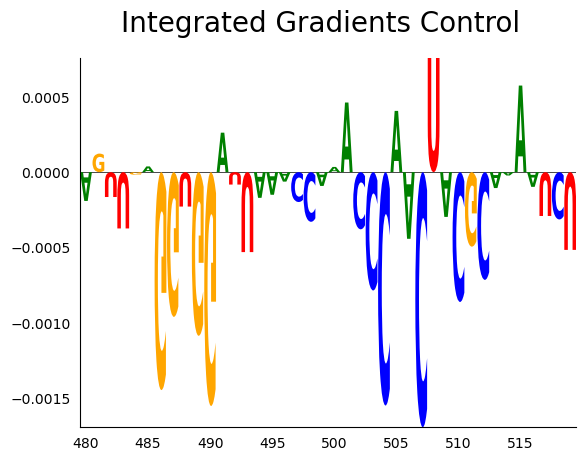

In [27]:
fig = plt.figure()
fig.suptitle("Integrated Gradients Control", fontsize=20)
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(1, 1, 1)
logomaker.Logo(df.iloc[480:520,:], ax=ax, color_scheme='classic')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("none")
ax.xaxis.set_ticks_position("none")
plt.show()

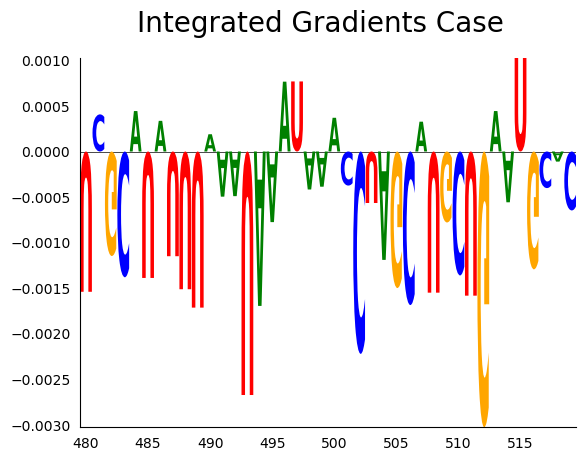

In [25]:
# Index = 1 -> case
# ~ 2 minutes
IG = random_baseline_integrated_gradients(inputs=top_1_case, model=model, index=1, steps=50, num_random_trials=10)

plot_matrix = np.average(np.multiply(top_1_case, IG), axis=0)
df = pd.DataFrame(plot_matrix.T, columns=list("ACGU"))
fig = plt.figure()
fig.suptitle("Integrated Gradients Case", fontsize=20)
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(1, 1, 1)
logomaker.Logo(df.iloc[480:520,:], ax=ax, color_scheme='classic')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("none")
ax.xaxis.set_ticks_position("none")
plt.show()

In [38]:
ig_captum = random_baseline_integrated_gradients(inputs=seq_fasta_one_hot[:10,:,:], model=model, index=0, steps=50, num_random_trials=10)

In [40]:
def calculate_outputs_and_gradients(inputs, model, index,cuda=False):
    # do the pre-processing
    predict_idx = None
    gradients = []
    n_steps = len(inputs)
    for i in range(n_steps):
        input = inputs[i]
        input.requires_grad = True
        input.retain_grad()
        output = model(input)
        # clear grad
        model.zero_grad()
        output[index].backward(retain_graph=True)
        gradient = input.grad.detach().cpu().numpy()[0]
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients

# integrated gradients
def integrated_gradients(inputs, model, predict_and_gradients, baseline, index,steps=50, cuda=False):
    if baseline is None:
        baseline = 0 * inputs
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = predict_and_gradients(scaled_inputs, model, index, cuda)
    avg_grads = np.average(grads[:-1], axis=0)
    avg_grads = np.expand_dims(avg_grads, axis=0)
    inputs = inputs.cpu().numpy()
    baseline = baseline.cpu().numpy()
    integrated_grad = (inputs - baseline) * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients(inputs, model, predict_and_gradients, index, steps, num_random_trials=10, cuda=True):
    all_intgrads = []
    length = inputs.shape[-1]        # input shape [1,4,length]
    mid = length // 2
    baseline = torch.cuda.FloatTensor(np.zeros(inputs.shape))
    # baseline[:,:,mid] = inputs[:,:,mid]
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients(inputs, model, predict_and_gradients, \
                                                baseline=baseline, \
                                                index=index, steps=steps, cuda=cuda)
        all_intgrads.append(integrated_grad)
        # print('the trial number is: {}'.format(i))
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads

In [ ]:
# one example from the med models, you can change the RBPname to see the attribution map of other RBPs in med models

X_test_seq = X_test_seq_med
X_test_region = X_test_region_med
y_test_RBP = y_test_RBP_med
RBPnames=RBPnames_med
pred=pred_med
igres=igres_med

RBPname="TARDBP"
RBP_index = np.where(RBPnames==RBPname)[0][0]
# Take the positive and with threshold > 0.5 
ind=[i[0] for i in sorted(enumerate(pred[:,RBP_index]), key=lambda x:x[1],reverse=True) if y_test_RBP[i[0],RBP_index]==1 and pred[i[0],RBP_index] > 0.50][0:3]
ex_seq=np.array([igres.explain([X_test_seq[i],X_test_region[i]],outc=RBP_index,reference=False)[0] for i in ind])

plt.close("all")
seqlogo_fig(np.transpose(ex_seq[:,25:125,:4],axes=(1,2,0)), vocab="RNA", figsize=(8,3), ncol=1)
plt.show()

In [ ]:
attributions = []
for j in range(len(multi_ind_high)):
    attribution = random_baseline_integrated_gradients(torch.unsqueeze(X[multi_ind_high[j],:],0), model, calculate_outputs_and_gradients, \
                                                        index = RM_index,steps=50, num_random_trials=10, cuda=None)
    attributions.append(attribution)
attributions = np.concatenate(attributions,0)

In [63]:
next(model.parameters()).device == torch.device("cpu")

True